# Exercises II
Let's set up an example scenario as perspective for our regression exercises using the Zillow dataset.

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

1. Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and    meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
from env import get_db_url

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

In [24]:
# Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, 
# and fips from the zillow database for all 'Single Family Residential' properties.

query = '''
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017
    WHERE propertylandusetypeid = 261
    '''
df = pd.read_sql(query, get_db_url('zillow'))
df.to_csv('zillow.csv', index=False)
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


Missing some values, bedroom and bathrooms are 0, maybe a new construction?

In [25]:
# Describe dataframe
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
count,2.152852e+06,2.152852e+06,2.144379e+06,2.152370e+06,2.143526e+06,2.148421e+06,2.152863e+06
mean,3.287196e+00,2.230688e+00,1.862855e+03,4.618962e+05,1.960950e+03,5.634866e+03,6.048377e+03
std,9.547544e-01,9.992796e-01,1.222125e+03,6.996760e+05,2.216220e+01,8.178910e+03,2.043329e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.801000e+03,1.850000e+00,6.037000e+03
25%,3.000000e+00,2.000000e+00,1.257000e+03,1.881702e+05,1.949000e+03,2.534980e+03,6.037000e+03
50%,3.000000e+00,2.000000e+00,1.623000e+03,3.276710e+05,1.958000e+03,4.108950e+03,6.037000e+03
75%,4.000000e+00,3.000000e+00,2.208000e+03,5.345270e+05,1.976000e+03,6.414320e+03,6.059000e+03
max,2.500000e+01,3.200000e+01,9.525760e+05,9.842891e+07,2.016000e+03,1.337756e+06,6.111000e+03


In [66]:
# Dataframe info
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2141219 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    2141208 non-null  float64
 1   bathrooms   2141208 non-null  float64
 2   sqfootage   2134287 non-null  float64
 3   tax_value   2141093 non-null  float64
 4   year_built  2133449 non-null  float64
 5   taxamount   2137868 non-null  float64
 6   fips        2141219 non-null  float64
dtypes: float64(7)
memory usage: 130.7 MB


/var/folders/_v/lfgsfb3n229bdhyjm1pj7f840000gn/T/ipykernel_4337/3845823123.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True)


They are all in a float format, which is ok

In [55]:
# look for null values
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    6932
taxvaluedollarcnt                126
yearbuilt                       7770
taxamount                       3351
fips                               0
dtype: int64

In [60]:
# shape
df.shape

(2141219, 7)

In [63]:
# renaming columns
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'sqfootage',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})

In [92]:
# Function to get zillow data
def get_zillow_data():    
    filename = 'zillow.csv'
    if os.path.exists(filename):
        print('Reading from csv file...')
        return pd.read_csv(filename)
      
    query = '''
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017
    WHERE propertylandusetypeid = 261
    '''
    print('Getting a fresh copy from SQL database...')
    df = pd.read_sql(query, get_db_url('zillow'))
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'sqfootage',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})
    print(df.head())
    print('Saving to csv...')
    df.to_csv(filename, index=False)
    return df

In [96]:
df = get_zillow_data()
df.head()

Reading from csv file...


,bedrooms,bathrooms,sqfootage,tax_value,year_built,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


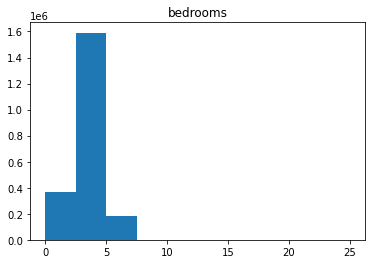

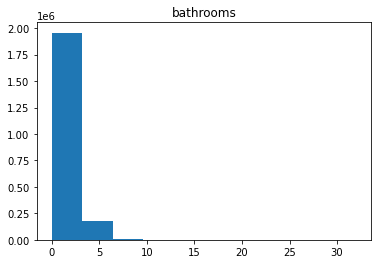

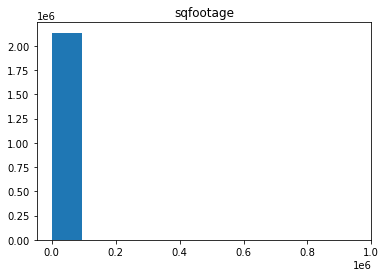

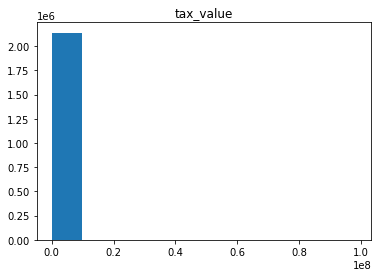

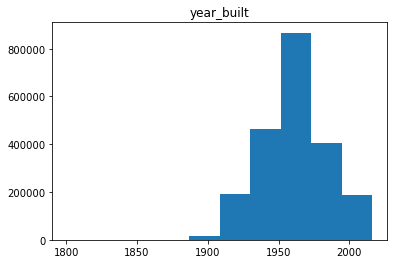

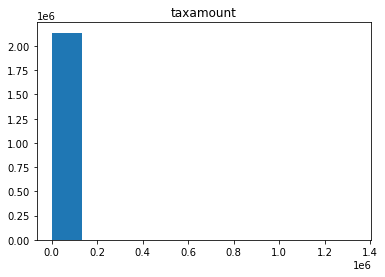

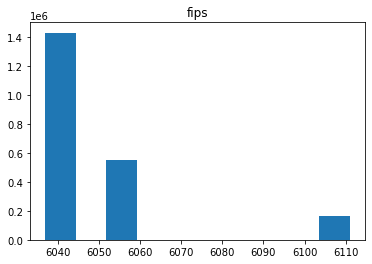

In [68]:
# Visualize Columns
columns = df.columns
for col in columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

### Takeaways
- a large separation between sets of numbers make histograms look useless
- a lot of null values
- bedroom count and year built should be integers
- fips can be made into an object as it has no numerical value

In [72]:
# drop duplicates
df = df.drop_duplicates()
df.shape

(2141219, 7)

In [76]:
# drop null values
df = df.dropna()
df.shape

(2130214, 7)

In [78]:
# we lose over 11k values if we drop NaN values
# less than 1%
2141219-2130214

11005

In [83]:
# change types
df[['bedrooms', 'year_built']] = df[['bedrooms', 'year_built']].astype(int)
df.fips = df.fips.astype(object)
df.dtypes

bedrooms        int64
bathrooms     float64
sqfootage     float64
tax_value     float64
year_built      int64
taxamount     float64
fips           object
dtype: object

In [110]:
# Function to clean Zillow data
def clean_zillow_data(df):
    # drop duplicates
    df = df.drop_duplicates()
    # drop null values
    df = df.dropna()
    # change types
    df[['bedrooms', 'year_built']] = df[['bedrooms', 'year_built']].astype(int)
    df.fips = df.fips.astype(object)
    return df


In [103]:
df=clean_zillow_data(df)
df.head()

,bedrooms,bathrooms,sqfootage,tax_value,year_built,taxamount,fips
4,4,2.0,3633.0,296425.0,2005,6941.39,6037.0
6,3,4.0,1620.0,847770.0,2011,10244.94,6037.0
7,3,2.0,2077.0,646760.0,1926,7924.68,6037.0
11,0,0.0,1200.0,5328.0,1972,91.60,6037.0
14,0,0.0,171.0,6920.0,1973,255.17,6037.0


In [88]:
  # train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=177)
train, validate = train_test_split(train_validate, test_size=.3, random_state=177)

In [89]:
train.shape, test.shape, validate.shape

((1192919, 7), (426043, 7), (511252, 7))

In [109]:
imputer = SimpleImputer(strategy='median')  # build imputer

imputer.fit(train[['year_built']]) # fit to train

# transform the data
train[['year_built']] = imputer.transform(train[['year_built']])
validate[['year_built']] = imputer.transform(validate[['year_built']])
test[['year_built']] = imputer.transform(test[['year_built']])

In [104]:
def wrangle_zillow():
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute year built using mode
    imputer = SimpleImputer(strategy='median')

    imputer.fit(train[['year_built']])

    train[['year_built']] = imputer.transform(train[['year_built']])
    validate[['year_built']] = imputer.transform(validate[['year_built']])
    test[['year_built']] = imputer.transform(test[['year_built']])       
    
    return train, validate, test    

In [108]:
train, validate, test = wrangle_zillow()
train.shape, validate.shape, test.shape

((1192919, 7), (511252, 7), (426043, 7))